In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [90]:
tickers = ["SPY"] 

data = yf.download(tickers, start = "2010-01-01", progress = False)
data.columns = data.columns.get_level_values(0)

close = data["Close"]

C:\Users\sidva\AppData\Local\Temp\ipykernel_29064\639231915.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start = "2010-01-01", progress = False)


In [91]:
#SMA Crossover
sma50 = data["Close"].rolling(window = 50).mean()
sma200 = data["Close"].rolling(window = 200).mean()

In [92]:
#Bollinger Bands
bb_mid = data["Close"].rolling(window = 20).mean()
bb_std = data["Close"].rolling(window = 20).std()
bb_upper = bb_mid + (bb_std*2)
bb_lower = bb_mid - (bb_std*2)

In [93]:
#RSI
delta = close.diff()
avg_gain = delta.where(delta > 0, 0).rolling(window = 14).mean()
avg_loss = (-delta.where(delta < 0, 0)).rolling(window = 14).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

In [94]:
#Attach columns
data["SMA50"] = sma50
data["SMA200"] = sma200
data["bb_lower"] = bb_lower
data["RSI"] = rsi

In [95]:
#Calculate ATR
a = data["High"] - data["Low"]
b = (data["High"] - data["Close"].shift(1)).abs()
c = (data["Low"] - data["Close"].shift(1)).abs()
data["TR"] = pd.concat([a, b, c], axis = 1).max(axis = 1)
data["ATR"] = data["TR"].rolling(window = 14).mean()

In [96]:
#Generate buy signals
#Conditions: Golden Cross(SMA),price is low(BB),momentum oversold(RSI) 
data = data.dropna(subset = ["SMA50","SMA200", "bb_lower", "RSI"])
data.reset_index(drop = True, inplace = True)

conditions = (
    (data["SMA50"].values > data["SMA200"].values) & 
    (data["Close"].values <= data["bb_lower"].values) &
    (data["RSI"].values < 40)
)

data["Signal"] = 0
data.loc[conditions, "Signal"] = 1

#Generate sell signals
position = False
entry_price = 0
exit_price = 0
days_held = 0
entry_atr = 0
results = []

for i in range(len(data)):
    if not position:
        if data["Signal"].iloc[i] == 1:
            position = True  
            days_held = 0
            entry_price = data["Close"].iloc[i]
            entry_atr = data["ATR"].iloc[i]
    else:
        days_held += 1
        
        if (data["RSI"].iloc[i] > 65 or 
        data["Close"].iloc[i] <= entry_price - (entry_atr * 2) or 
        days_held >= 30):

            exit_price = data["Close"].iloc[i]
            pct_exit_price = (exit_price - entry_price)/entry_price * 100
            results.append(pct_exit_price)
            position = False

In [97]:
#Performance Metrics
win_rate = 0
avg_return = 0
for i in results:
    if i > 0:
        win_rate += 1
    final_win_rate = win_rate / len(results) * 100
    final_avg_return = sum(results)/len(results)

print(f"Win Rate:", {final_win_rate})
print(f"Avg Return:", {final_avg_return})

Win Rate: {62.06896551724138}
Avg Return: {np.float64(1.2869249278097992)}


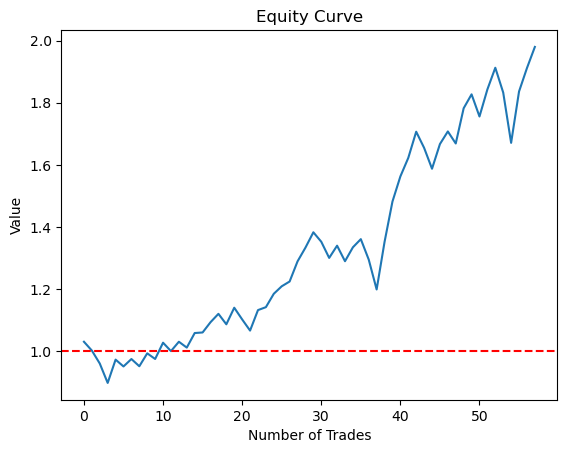

In [98]:
#Equity Curve
new_array = np.array(results)
multipliers = 1 + (np.array(results)/100)
equity_curve = multipliers.cumprod()
plt.plot(equity_curve)
plt.axhline(1, color = "red", linestyle = "--")
plt.title("Equity Curve")
plt.xlabel("Number of Trades")
plt.ylabel("Value")
plt.show()